In [ ]:
import pandas as pd
from datetime import datetime, timedelta

In [1]:
gdd.download_file_from_google_drive(file_id="122XXMOwYgMxvgAVrm_VwXnyV42IgBiiC", dest_path="D:/household_power_consumption.csv")

raw_data = pd.read_csv("D:/household_power_consumption.csv", header=0, infer_datetime_format=True, parse_dates=["datetime"], index_col=["datetime"])

In [2]:
all_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766666
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733334
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


In [3]:
daily_groups = all_df.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())

(1442, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]


In [4]:
daily_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011
...,...,...,...,...,...,...,...,...
2010-11-22,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,10136.0,16924.600023
2010-11-23,1577.536,137.450,346428.76,6731.2,1871.0,458.0,7611.0,16352.266679
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0,13769.466664


In [5]:
dataset = daily_data

# Helper

In [6]:
import numpy as np
from numpy import split
from numpy import array

def split_dataset(data):
	train, test = data[1:-328], data[-328:-6]

	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

In [7]:
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


In [8]:
from sklearn.metrics import mean_squared_error

def evaluate_forecasts(actual, predicted):
	scores = list()
	for i in range(actual.shape[1]):
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		rmse = sqrt(mse)
		scores.append(rmse)
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [9]:
def evaluate_model(train, test, n_input):
	model = build_model(train, n_input)
	history = [x for x in train]
	predictions = list()
	for i in range(len(test)):
		yhat_sequence = forecast(model, history, n_input)
		predictions.append(yhat_sequence)
		history.append(test[i, :])
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [10]:
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [11]:
def to_supervised(train, n_input, n_out=7):
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	for _ in range(len(data)):
		in_end = in_start + n_input
		out_end = in_end + n_out
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		in_start += 1
	return array(X), array(y)

# HELPER

## Seq2Seq 모델링 시작.

# LSTM 코드

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def build_model(train, n_input):
	train_x, train_y = to_supervised(train, n_input)
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# 모델의 시작. => 순차적으로 입력이 들어가는 경우는 Sequential
	model = Sequential()
  # LSTM => CNN-LSTM => 과제.
	model.add(LSTM(200, 
	               activation='relu', 
								  input_shape=(n_timesteps, n_features))
 ) # encoder state를 만듬.
	model.add(Dense(1024)) # <= encoder state. encoder state의 차원을 지정. 
	model.add(RepeatVector(n_outputs)) # 앞에 레이어의 출력이 뒤에 레이어에 반복해서 입력으로 들어감.
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 
def forecast(model, history, n_input):
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	input_x = data[-n_input:, 0]
	input_x = input_x.reshape((1, len(input_x), 1))
	yhat = model.predict(input_x, verbose=0)
	yhat = yhat[0]
	return yhat

# CNN-LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


def build_model(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    model = Sequential()

                # conv => 요약된 정보의 차원:64, kernel_size=window 사이즈, 3 
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
	          input_shape=(n_timesteps, n_features)))
                # conv => 64차원, window 3
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) # 1주까지 요약
    model.add(MaxPooling1D(pool_size=2)) # 중요한 정보만 남김
    model.add(Flatten())  # 펼침
    model.add(RepeatVector(n_outputs)) # 펼친 벡터를 LSTM에다가 각각 입력으로 넣음.
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, activation='relu')) # encoder state
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
 
def forecast(model, history, n_input):
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	input_x = data[-n_input:, 0]
	input_x = input_x.reshape((1, len(input_x), 1))
	yhat = model.predict(input_x, verbose=0)
	yhat = yhat[0]
	return yhat

# CNN-LSTM

lstm: [377.349] 384.1, 386.7, 341.4, 370.4, 385.6, 308.3, 449.7


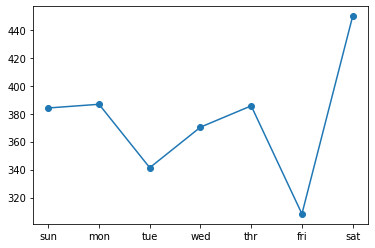

In [13]:
from math import sqrt
import matplotlib.pyplot as plt

n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
plt.plot(days, scores, marker='o', label='lstm')
plt.show()

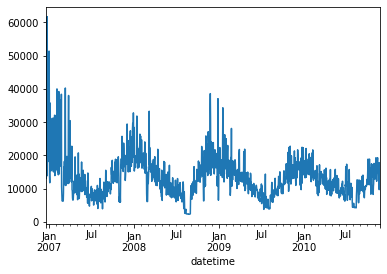

In [ ]:
dataset['sub_metering_4'].plot()